In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score
source_folder = 'Data'

In [2]:
def spearman(x,y):
    return spearmanr(x,y)

In [3]:
def multi_class_spearman(true, pred):
    return spearman(true, pred)

In [4]:
def multi_class_roc_auc(true, pred, average = 'macro'):
    #print(true)
    return roc_auc_score(true, pred, average = average)

In [5]:
train = pd.read_csv(source_folder+'/train.csv', sep=',')
valid = pd.read_csv(source_folder+'/valid.csv', sep=',')
test = pd.read_csv(source_folder+'/test.csv', sep=',')

In [6]:
train['comment'] = train['comment'].str.lower()
valid['comment'] = valid['comment'].str.lower()
test['comment'] = test['comment'].str.lower()

In [7]:
X_train = train['comment']
y_train = train['attack'].values

X_test = test['comment']
y_test = test['attack'].values

In [8]:
pipeline = Pipeline([
    ('vect', CountVectorizer(binary=True, analyzer='char', ngram_range=(1,5), min_df = 10, max_df = 0.95)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', LogisticRegression(C=10, max_iter=1000))
])

In [9]:
train_feature_set=pipeline.fit(train['comment'].values, y_train).predict(train['comment'].values)
test_feature_set=pipeline.fit(test['comment'].values, y_test).predict(test['comment'].values)

In [10]:
y_pred = pipeline.predict(test['comment'].values)

In [11]:
print("Spearman: ", multi_class_spearman(y_test, y_pred))
print("AUC score: ", multi_class_roc_auc(y_test, y_pred))

Spearman:  SpearmanrResult(correlation=0.9648226612344294, pvalue=0.0)
AUC score:  0.9723111973462965


In [12]:
feature_importance = pipeline['clf'].coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(pipeline['vect'].vocabulary_.keys())[list(pipeline['vect'].vocabulary_.values()).index(i)], 'Score: ', v)

Feature:   ! Score:  0.05052712892135214
Feature:   !  Score:  -0.58502553683406
Feature:   ! w Score:  -0.09210648387902247
Feature:   !! Score:  0.9163146177809893
Feature:   !!  Score:  -0.19134526639608243
Feature:   !!! Score:  0.6913761837870611
Feature:   !!!  Score:  0.3262956120713321
Feature:   !!!! Score:  0.4333196014029083
Feature:   !n Score:  -0.3256463054988873
Feature:   !ne Score:  -0.3256463054988873


In [13]:
feature_importance = pipeline['clf'].coef_[0]
sorted_idx = np.argsort(feature_importance)

In [14]:
top_10_attack = [list(pipeline['vect'].vocabulary_.keys())[list(pipeline['vect'].vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_attack)

['uck', 'fuc', 'fuck', 'uc', 'shit', ' fuc', ' fuck', 'suck', ' suck', 'uck ']


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


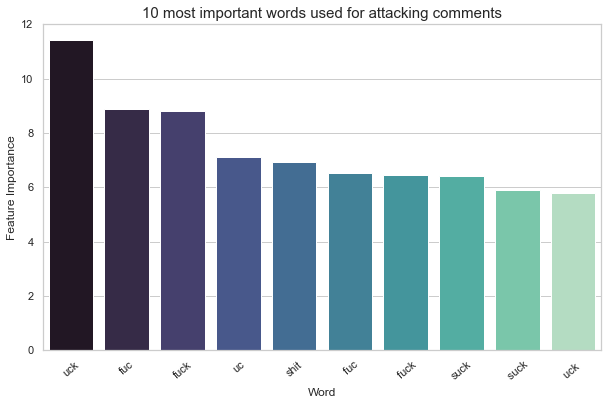

In [15]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_attack, feature_importance[sorted_idx[range(-1,-11, -1)]], palette="mako")
plt.title("10 most important words used for attacking comments",fontsize = 15)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);
plt.savefig('Figures/AttackWordVectors.png')

In [16]:
sub_f = train.loc[train.comment.str.contains('fuck')]
round(sub_f.attack.mean(),3)

0.929

In [17]:
top_10_non_attack = [list(pipeline['vect'].vocabulary_.keys())[list(pipeline['vect'].vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_non_attack)

['?', ':', '. ', 'hank ', 'ank ', 'the b', 'ank y', 'i do', 'the p', 'hank']


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


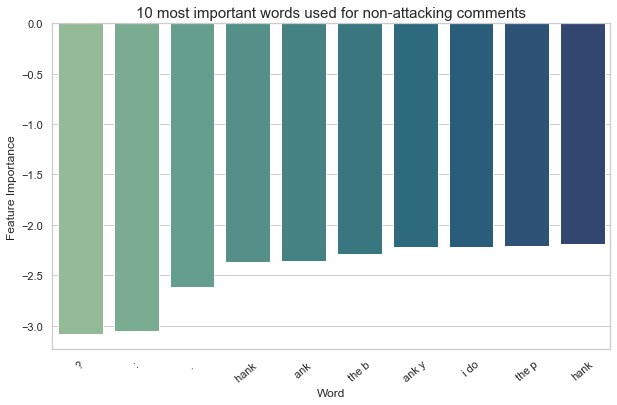

In [18]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_non_attack, feature_importance[sorted_idx[:10]], palette="crest")
plt.title("10 most important words used for non-attacking comments",fontsize = 15)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);
plt.savefig('Figures/NonAttackWordVectors.png')